<h1 style="text-align:center">Machine Learning</h1>

In [42]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import DMatrix
from xgboost import cv

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from time import time

<h3 style="text-align:center">Combine dataset</h3>

In [16]:
# Load files
train_df = pd.read_pickle('train_df.p')
test_df = pd.read_pickle('test_df.p')
target  = pd.read_pickle('target.p')

train_OSRM = pd.read_pickle('train_OSRM.p')
test_OSRM = pd.read_pickle('test_OSRM.p')

In [17]:
train_df.shape

(1458621, 16)

In [18]:
train_OSRM.shape

(1458643, 4)

In [5]:
# train.merge(train_street_info, how='left', on='id')

train_df = train_OSRM.merge(train_df, how='right', on='id')
test_df = test_OSRM.merge(test_df, how='right', on='id')

In [6]:
print("Train shape:", train_df.shape)
print("Target shape:", target.shape)
print("Test shape:", test_df.shape)

Train shape: (1458621, 19)
Target shape: (1458621, 1)
Test shape: (625134, 18)


In [7]:
train_df.head()

,id,total_distance,total_travel_time,number_of_steps,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,weekend,pickup_pca0,pickup_pca1,pickup_cluster,sqrt_distance,Pickup_NumDayWeek,Month,Pickup_Day,Pickup_Hour,Pickup_Minute,Pickup_NumWeekYear
0,id2875421,2009.1,164.9,5.0,2,1,0,455,0,0.008300,0.017177,67,1.224313,0,3,14,17,24,11
1,id2377394,2513.2,332.0,6.0,1,1,0,663,1,0.007128,-0.012224,49,1.343881,6,6,12,0,43,23
2,id3504673,1779.4,235.8,4.0,2,1,0,429,0,0.037106,-0.030242,94,1.218982,2,4,6,19,32,14
3,id2181028,1614.9,140.1,5.0,2,1,0,435,1,-0.001287,0.042269,84,1.090378,5,3,26,13,30,12
4,id0801584,1393.5,189.4,5.0,2,3,0,443,1,0.009499,-0.008546,64,1.048452,5,1,30,22,1,4


<h3 style="text-align:center">Split-out dataset</h3>

In [8]:
# Test options and evaluation metric
num_folds = 10 
seed = 46
test_size = 0.20
scoring = 'r2'

In [19]:
X = train_df.drop(['id', 'trip_duration'], axis=1).values
Y = target.values.ravel()

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=test_size,\
                                                   random_state=seed)


In [10]:
print(X_train.shape, y_train.shape, "\n", X_val.shape, y_val.shape)

(1166896, 17) (1166896,) 
 (291725, 17) (291725,)


<h3 style="text-align:center">Tuning Algorithm</h3>

In [26]:
# Create DMatrix to make XGboost more efficient
xgdmat = DMatrix(X_train, y_train)
testdmat = DMatrix(X_val)

In [15]:
start = time()

our_params = {'eta': 1, 'seed':seed, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'max_depth':5, 'min_child_weight':50} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 100)

print("elapsed time:", round(time()-start, 3), "s")

# Test to see how well we did on test set
y_pred = final_gb.predict(testdmat)
accuracy = r2_score(y_val, y_pred)
print(accuracy)

elapsed time: 80.233 s
-0.0122849496736


In [23]:
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

-0.0001511116325


In [33]:
start = time()

our_params = {'eta': 0.05, 'seed':seed, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'max_depth':5, 'min_child_weight':10} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 300)

print("elapsed time:", round(time()-start, 3), "s")

# Test to see how well we did on test set
y_pred = final_gb.predict(testdmat)
accuracy = r2_score(y_val, y_pred)
print(accuracy)

elapsed time: 229.021 s
0.687916419522


In [29]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [33]:
start = time()

our_params = {'eta': 0.05, 'seed':seed, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'max_depth':5, 'min_child_weight':10} 

final_gb = xgb.train(
    our_params, 
    xgdmat,
    300,
    watchlist,
    
    early_stopping_rounds=100, 
#     verbose_eval=10
                    )

print("elapsed time:", round(time()-start, 3), "s")

# Test to see how well we did on test set
y_pred = final_gb.predict(testdmat)
accuracy = r2_score(y_val, y_pred)
print(accuracy)

[0]	train-rmse:5.7219	valid-rmse:5.72136
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[1]	train-rmse:5.43799	valid-rmse:5.43749
[2]	train-rmse:5.16843	valid-rmse:5.16795
[3]	train-rmse:4.91242	valid-rmse:4.91198
[4]	train-rmse:4.66933	valid-rmse:4.66894
[5]	train-rmse:4.43855	valid-rmse:4.43818
[6]	train-rmse:4.2194	valid-rmse:4.21907
[7]	train-rmse:4.01348	valid-rmse:4.01321
[8]	train-rmse:3.81581	valid-rmse:3.81558
[9]	train-rmse:3.62817	valid-rmse:3.62797
[10]	train-rmse:3.4501	valid-rmse:3.44995
[11]	train-rmse:3.2811	valid-rmse:3.28102
[12]	train-rmse:3.12071	valid-rmse:3.12067
[13]	train-rmse:2.9685	valid-rmse:2.96849
[14]	train-rmse:2.82581	valid-rmse:2.82585
[15]	train-rmse:2.6887	valid-rmse:2.68878
[16]	train-rmse:2.5587	valid-rmse:2.55883
[17]	train-rmse:2.4354	valid-rmse:2.43558
[18]	train-rmse:2.31848	valid-rmse:2.31871
[19]	train-rmse:2.20769	valid-rmse:2.20797
[20]	train-r

[180]	train-rmse:0.446603	valid-rmse:0.451419
[181]	train-rmse:0.446545	valid-rmse:0.451361
[182]	train-rmse:0.446487	valid-rmse:0.451312
[183]	train-rmse:0.44645	valid-rmse:0.451286
[184]	train-rmse:0.446375	valid-rmse:0.451215
[185]	train-rmse:0.446317	valid-rmse:0.451179
[186]	train-rmse:0.446276	valid-rmse:0.451142
[187]	train-rmse:0.446225	valid-rmse:0.451102
[188]	train-rmse:0.446152	valid-rmse:0.451032
[189]	train-rmse:0.446106	valid-rmse:0.450998
[190]	train-rmse:0.446039	valid-rmse:0.450944
[191]	train-rmse:0.445994	valid-rmse:0.450906
[192]	train-rmse:0.445929	valid-rmse:0.450847
[193]	train-rmse:0.445895	valid-rmse:0.450831
[194]	train-rmse:0.445855	valid-rmse:0.450808
[195]	train-rmse:0.44581	valid-rmse:0.450768
[196]	train-rmse:0.445746	valid-rmse:0.450715
[197]	train-rmse:0.445668	valid-rmse:0.450641
[198]	train-rmse:0.445579	valid-rmse:0.450557
[199]	train-rmse:0.445522	valid-rmse:0.450503
[200]	train-rmse:0.445491	valid-rmse:0.450483
[201]	train-rmse:0.445434	valid-rmse

In [34]:
start = time()

our_params = {'eta': 0.05, 'seed':seed, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'max_depth':5, 'min_child_weight':10} 

final_gb = xgb.train(
    our_params, 
    xgdmat,
    3000,
    watchlist,
    
    early_stopping_rounds=100, 
#     verbose_eval=10
                    )

print("elapsed time:", round(time()-start, 3), "s")

# Test to see how well we did on test set
y_pred = final_gb.predict(testdmat)
accuracy = r2_score(y_val, y_pred)
print(accuracy)

[0]	train-rmse:5.7219	valid-rmse:5.72136
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[1]	train-rmse:5.43799	valid-rmse:5.43749
[2]	train-rmse:5.16843	valid-rmse:5.16795
[3]	train-rmse:4.91242	valid-rmse:4.91198
[4]	train-rmse:4.66933	valid-rmse:4.66894
[5]	train-rmse:4.43855	valid-rmse:4.43818
[6]	train-rmse:4.2194	valid-rmse:4.21907
[7]	train-rmse:4.01348	valid-rmse:4.01321
[8]	train-rmse:3.81581	valid-rmse:3.81558
[9]	train-rmse:3.62817	valid-rmse:3.62797
[10]	train-rmse:3.4501	valid-rmse:3.44995
[11]	train-rmse:3.2811	valid-rmse:3.28102
[12]	train-rmse:3.12071	valid-rmse:3.12067
[13]	train-rmse:2.9685	valid-rmse:2.96849
[14]	train-rmse:2.82581	valid-rmse:2.82585
[15]	train-rmse:2.6887	valid-rmse:2.68878
[16]	train-rmse:2.5587	valid-rmse:2.55883
[17]	train-rmse:2.4354	valid-rmse:2.43558
[18]	train-rmse:2.31848	valid-rmse:2.31871
[19]	train-rmse:2.20769	valid-rmse:2.20797
[20]	train-r

[180]	train-rmse:0.446603	valid-rmse:0.451419
[181]	train-rmse:0.446545	valid-rmse:0.451361
[182]	train-rmse:0.446487	valid-rmse:0.451312
[183]	train-rmse:0.44645	valid-rmse:0.451286
[184]	train-rmse:0.446375	valid-rmse:0.451215
[185]	train-rmse:0.446317	valid-rmse:0.451179
[186]	train-rmse:0.446276	valid-rmse:0.451142
[187]	train-rmse:0.446225	valid-rmse:0.451102
[188]	train-rmse:0.446152	valid-rmse:0.451032
[189]	train-rmse:0.446106	valid-rmse:0.450998
[190]	train-rmse:0.446039	valid-rmse:0.450944
[191]	train-rmse:0.445994	valid-rmse:0.450906
[192]	train-rmse:0.445929	valid-rmse:0.450847
[193]	train-rmse:0.445895	valid-rmse:0.450831
[194]	train-rmse:0.445855	valid-rmse:0.450808
[195]	train-rmse:0.44581	valid-rmse:0.450768
[196]	train-rmse:0.445746	valid-rmse:0.450715
[197]	train-rmse:0.445668	valid-rmse:0.450641
[198]	train-rmse:0.445579	valid-rmse:0.450557
[199]	train-rmse:0.445522	valid-rmse:0.450503
[200]	train-rmse:0.445491	valid-rmse:0.450483
[201]	train-rmse:0.445434	valid-rmse

[359]	train-rmse:0.440573	valid-rmse:0.447056
[360]	train-rmse:0.440541	valid-rmse:0.447027
[361]	train-rmse:0.440522	valid-rmse:0.447022
[362]	train-rmse:0.440513	valid-rmse:0.447015
[363]	train-rmse:0.440488	valid-rmse:0.447022
[364]	train-rmse:0.440464	valid-rmse:0.447014
[365]	train-rmse:0.440451	valid-rmse:0.447005
[366]	train-rmse:0.440442	valid-rmse:0.447
[367]	train-rmse:0.440435	valid-rmse:0.446997
[368]	train-rmse:0.440413	valid-rmse:0.446991
[369]	train-rmse:0.440402	valid-rmse:0.446983
[370]	train-rmse:0.440385	valid-rmse:0.44697
[371]	train-rmse:0.44038	valid-rmse:0.446969
[372]	train-rmse:0.440372	valid-rmse:0.446968
[373]	train-rmse:0.440335	valid-rmse:0.446938
[374]	train-rmse:0.440294	valid-rmse:0.446902
[375]	train-rmse:0.44029	valid-rmse:0.446905
[376]	train-rmse:0.440275	valid-rmse:0.446891
[377]	train-rmse:0.440242	valid-rmse:0.446867
[378]	train-rmse:0.440222	valid-rmse:0.446878
[379]	train-rmse:0.440194	valid-rmse:0.446858
[380]	train-rmse:0.440184	valid-rmse:0.4

[539]	train-rmse:0.43727	valid-rmse:0.445494
[540]	train-rmse:0.437246	valid-rmse:0.445508
[541]	train-rmse:0.437234	valid-rmse:0.445513
[542]	train-rmse:0.437228	valid-rmse:0.44551
[543]	train-rmse:0.437209	valid-rmse:0.445517
[544]	train-rmse:0.437191	valid-rmse:0.44551
[545]	train-rmse:0.437183	valid-rmse:0.445508
[546]	train-rmse:0.437179	valid-rmse:0.445504
[547]	train-rmse:0.437139	valid-rmse:0.445473
[548]	train-rmse:0.437109	valid-rmse:0.445462
[549]	train-rmse:0.437096	valid-rmse:0.445462
[550]	train-rmse:0.437081	valid-rmse:0.445457
[551]	train-rmse:0.43707	valid-rmse:0.445445
[552]	train-rmse:0.437021	valid-rmse:0.445399
[553]	train-rmse:0.437003	valid-rmse:0.445384
[554]	train-rmse:0.436999	valid-rmse:0.445385
[555]	train-rmse:0.436998	valid-rmse:0.445385
[556]	train-rmse:0.43698	valid-rmse:0.445377
[557]	train-rmse:0.436968	valid-rmse:0.445367
[558]	train-rmse:0.436955	valid-rmse:0.44537
[559]	train-rmse:0.436934	valid-rmse:0.445358
[560]	train-rmse:0.436918	valid-rmse:0.4

[719]	train-rmse:0.434777	valid-rmse:0.444727
[720]	train-rmse:0.434769	valid-rmse:0.444726
[721]	train-rmse:0.434757	valid-rmse:0.444719
[722]	train-rmse:0.434749	valid-rmse:0.444714
[723]	train-rmse:0.434743	valid-rmse:0.444708
[724]	train-rmse:0.434725	valid-rmse:0.444704
[725]	train-rmse:0.434715	valid-rmse:0.444697
[726]	train-rmse:0.434698	valid-rmse:0.444688
[727]	train-rmse:0.434689	valid-rmse:0.444679
[728]	train-rmse:0.434675	valid-rmse:0.444675
[729]	train-rmse:0.43467	valid-rmse:0.444676
[730]	train-rmse:0.434668	valid-rmse:0.444675
[731]	train-rmse:0.434656	valid-rmse:0.444676
[732]	train-rmse:0.434654	valid-rmse:0.444677
[733]	train-rmse:0.434653	valid-rmse:0.444678
[734]	train-rmse:0.434641	valid-rmse:0.444668
[735]	train-rmse:0.434632	valid-rmse:0.444662
[736]	train-rmse:0.434609	valid-rmse:0.444655
[737]	train-rmse:0.434606	valid-rmse:0.444656
[738]	train-rmse:0.434599	valid-rmse:0.444652
[739]	train-rmse:0.434596	valid-rmse:0.444651
[740]	train-rmse:0.434575	valid-rms

[899]	train-rmse:0.432639	valid-rmse:0.44419
[900]	train-rmse:0.432629	valid-rmse:0.444186
[901]	train-rmse:0.432613	valid-rmse:0.444172
[902]	train-rmse:0.432607	valid-rmse:0.444172
[903]	train-rmse:0.432593	valid-rmse:0.444172
[904]	train-rmse:0.432592	valid-rmse:0.444173
[905]	train-rmse:0.432583	valid-rmse:0.444179
[906]	train-rmse:0.432581	valid-rmse:0.444181
[907]	train-rmse:0.432557	valid-rmse:0.444167
[908]	train-rmse:0.432537	valid-rmse:0.444159
[909]	train-rmse:0.432524	valid-rmse:0.444149
[910]	train-rmse:0.43252	valid-rmse:0.444147
[911]	train-rmse:0.432503	valid-rmse:0.44414
[912]	train-rmse:0.432501	valid-rmse:0.444141
[913]	train-rmse:0.432476	valid-rmse:0.444123
[914]	train-rmse:0.432474	valid-rmse:0.444122
[915]	train-rmse:0.432472	valid-rmse:0.444121
[916]	train-rmse:0.432469	valid-rmse:0.444118
[917]	train-rmse:0.43246	valid-rmse:0.444111
[918]	train-rmse:0.432458	valid-rmse:0.444108
[919]	train-rmse:0.432452	valid-rmse:0.444108
[920]	train-rmse:0.432437	valid-rmse:0

[1077]	train-rmse:0.43085	valid-rmse:0.443709
[1078]	train-rmse:0.430836	valid-rmse:0.443703
[1079]	train-rmse:0.430822	valid-rmse:0.443691
[1080]	train-rmse:0.43082	valid-rmse:0.443689
[1081]	train-rmse:0.430811	valid-rmse:0.443681
[1082]	train-rmse:0.430795	valid-rmse:0.443667
[1083]	train-rmse:0.430788	valid-rmse:0.443669
[1084]	train-rmse:0.430771	valid-rmse:0.443677
[1085]	train-rmse:0.430756	valid-rmse:0.443669
[1086]	train-rmse:0.430751	valid-rmse:0.443668
[1087]	train-rmse:0.430739	valid-rmse:0.443666
[1088]	train-rmse:0.430722	valid-rmse:0.443664
[1089]	train-rmse:0.430717	valid-rmse:0.443663
[1090]	train-rmse:0.430702	valid-rmse:0.44366
[1091]	train-rmse:0.430693	valid-rmse:0.443662
[1092]	train-rmse:0.430683	valid-rmse:0.443654
[1093]	train-rmse:0.430678	valid-rmse:0.443654
[1094]	train-rmse:0.430668	valid-rmse:0.443647
[1095]	train-rmse:0.430652	valid-rmse:0.443648
[1096]	train-rmse:0.430646	valid-rmse:0.443649
[1097]	train-rmse:0.430636	valid-rmse:0.443642
[1098]	train-rms

[1253]	train-rmse:0.429233	valid-rmse:0.443492
[1254]	train-rmse:0.42922	valid-rmse:0.443486
[1255]	train-rmse:0.429219	valid-rmse:0.443486
[1256]	train-rmse:0.429218	valid-rmse:0.443486
[1257]	train-rmse:0.429206	valid-rmse:0.443475
[1258]	train-rmse:0.429193	valid-rmse:0.443469
[1259]	train-rmse:0.429186	valid-rmse:0.443469
[1260]	train-rmse:0.429175	valid-rmse:0.443485
[1261]	train-rmse:0.429169	valid-rmse:0.44348
[1262]	train-rmse:0.429159	valid-rmse:0.443487
[1263]	train-rmse:0.429154	valid-rmse:0.443492
[1264]	train-rmse:0.429152	valid-rmse:0.443492
[1265]	train-rmse:0.429133	valid-rmse:0.443475
[1266]	train-rmse:0.429123	valid-rmse:0.443471
[1267]	train-rmse:0.42912	valid-rmse:0.443468
[1268]	train-rmse:0.429109	valid-rmse:0.443468
[1269]	train-rmse:0.429107	valid-rmse:0.443467
[1270]	train-rmse:0.429096	valid-rmse:0.443463
[1271]	train-rmse:0.429089	valid-rmse:0.44346
[1272]	train-rmse:0.429074	valid-rmse:0.443456
[1273]	train-rmse:0.429064	valid-rmse:0.443454
[1274]	train-rmse

[1429]	train-rmse:0.427607	valid-rmse:0.443153
[1430]	train-rmse:0.427603	valid-rmse:0.443158
[1431]	train-rmse:0.427594	valid-rmse:0.443158
[1432]	train-rmse:0.427588	valid-rmse:0.443156
[1433]	train-rmse:0.427585	valid-rmse:0.443156
[1434]	train-rmse:0.427579	valid-rmse:0.443156
[1435]	train-rmse:0.427565	valid-rmse:0.443162
[1436]	train-rmse:0.427564	valid-rmse:0.443161
[1437]	train-rmse:0.427556	valid-rmse:0.443162
[1438]	train-rmse:0.427554	valid-rmse:0.443161
[1439]	train-rmse:0.427547	valid-rmse:0.443157
[1440]	train-rmse:0.427541	valid-rmse:0.443155
[1441]	train-rmse:0.427533	valid-rmse:0.443153
[1442]	train-rmse:0.427531	valid-rmse:0.443153
[1443]	train-rmse:0.427521	valid-rmse:0.443153
[1444]	train-rmse:0.427518	valid-rmse:0.443155
[1445]	train-rmse:0.427506	valid-rmse:0.443158
[1446]	train-rmse:0.427495	valid-rmse:0.443148
[1447]	train-rmse:0.427489	valid-rmse:0.443149
[1448]	train-rmse:0.427479	valid-rmse:0.443151
[1449]	train-rmse:0.427469	valid-rmse:0.44315
[1450]	train-r

[1604]	train-rmse:0.426262	valid-rmse:0.442995
[1605]	train-rmse:0.426249	valid-rmse:0.442992
[1606]	train-rmse:0.426247	valid-rmse:0.442991
[1607]	train-rmse:0.426235	valid-rmse:0.442998
[1608]	train-rmse:0.426225	valid-rmse:0.443005
[1609]	train-rmse:0.426216	valid-rmse:0.443002
[1610]	train-rmse:0.42621	valid-rmse:0.443001
[1611]	train-rmse:0.426194	valid-rmse:0.442993
[1612]	train-rmse:0.426185	valid-rmse:0.442995
[1613]	train-rmse:0.426177	valid-rmse:0.442999
[1614]	train-rmse:0.42616	valid-rmse:0.442986
[1615]	train-rmse:0.426155	valid-rmse:0.442982
[1616]	train-rmse:0.426148	valid-rmse:0.442981
[1617]	train-rmse:0.426137	valid-rmse:0.442982
[1618]	train-rmse:0.426124	valid-rmse:0.442972
[1619]	train-rmse:0.426114	valid-rmse:0.442968
[1620]	train-rmse:0.426111	valid-rmse:0.442966
[1621]	train-rmse:0.426108	valid-rmse:0.442964
[1622]	train-rmse:0.4261	valid-rmse:0.442965
[1623]	train-rmse:0.426094	valid-rmse:0.442965
[1624]	train-rmse:0.426084	valid-rmse:0.442973
[1625]	train-rmse

[1780]	train-rmse:0.424988	valid-rmse:0.442892
[1781]	train-rmse:0.424976	valid-rmse:0.442888
[1782]	train-rmse:0.42497	valid-rmse:0.442885
[1783]	train-rmse:0.42496	valid-rmse:0.442886
[1784]	train-rmse:0.424952	valid-rmse:0.442881
[1785]	train-rmse:0.424945	valid-rmse:0.442879
[1786]	train-rmse:0.42494	valid-rmse:0.442877
[1787]	train-rmse:0.424927	valid-rmse:0.442873
[1788]	train-rmse:0.424917	valid-rmse:0.442873
[1789]	train-rmse:0.424912	valid-rmse:0.442872
[1790]	train-rmse:0.424905	valid-rmse:0.442872
[1791]	train-rmse:0.424899	valid-rmse:0.442874
[1792]	train-rmse:0.424895	valid-rmse:0.442874
[1793]	train-rmse:0.424887	valid-rmse:0.442876
[1794]	train-rmse:0.424876	valid-rmse:0.442878
[1795]	train-rmse:0.424867	valid-rmse:0.442874
[1796]	train-rmse:0.424855	valid-rmse:0.44287
[1797]	train-rmse:0.424846	valid-rmse:0.442869
[1798]	train-rmse:0.424841	valid-rmse:0.442866
[1799]	train-rmse:0.424836	valid-rmse:0.442866
[1800]	train-rmse:0.424831	valid-rmse:0.442867
[1801]	train-rmse

[1956]	train-rmse:0.423689	valid-rmse:0.442784
[1957]	train-rmse:0.423687	valid-rmse:0.442784
[1958]	train-rmse:0.423672	valid-rmse:0.442775
[1959]	train-rmse:0.423663	valid-rmse:0.442778
[1960]	train-rmse:0.423653	valid-rmse:0.442784
[1961]	train-rmse:0.423638	valid-rmse:0.442788
[1962]	train-rmse:0.423626	valid-rmse:0.442789
[1963]	train-rmse:0.423624	valid-rmse:0.442788
[1964]	train-rmse:0.423617	valid-rmse:0.442792
[1965]	train-rmse:0.423613	valid-rmse:0.442792
[1966]	train-rmse:0.423603	valid-rmse:0.442786
[1967]	train-rmse:0.423595	valid-rmse:0.442784
[1968]	train-rmse:0.423584	valid-rmse:0.442774
[1969]	train-rmse:0.423579	valid-rmse:0.442772
[1970]	train-rmse:0.423572	valid-rmse:0.442774
[1971]	train-rmse:0.423561	valid-rmse:0.442774
[1972]	train-rmse:0.423555	valid-rmse:0.442771
[1973]	train-rmse:0.423549	valid-rmse:0.44277
[1974]	train-rmse:0.423541	valid-rmse:0.442767
[1975]	train-rmse:0.42354	valid-rmse:0.442767
[1976]	train-rmse:0.423533	valid-rmse:0.442775
[1977]	train-rm

<h3 style="text-align:center">Checking Model</h3>


In [36]:
X_fin = test_df.drop(['id'], axis=1).values
X_fin_dmat = DMatrix(X_fin)

In [38]:
y_final_pred = final_gb.predict(X_fin_dmat)
y_final_pred

array([ 6.58899879,  6.38604498,  5.93437004, ...,  7.38370943,
        7.75163651,  7.04049873], dtype=float32)

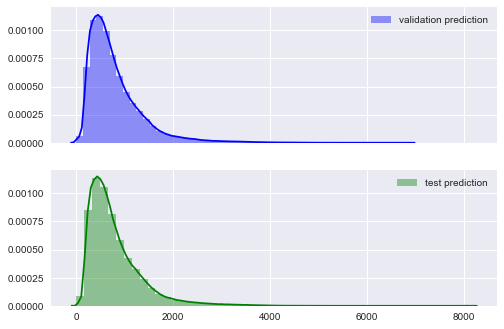

Validation prediction mean: 794.127
Test prediction mean: 789.374


In [45]:
validation_pred = np.exp(y_pred)
final_pred = np.exp(y_final_pred)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(validation_pred, ax=ax[0], color='blue',
            label='validation prediction')
sns.distplot(final_pred, ax=ax[1], color='green',
            label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

print('Validation prediction mean: %.3f' % (validation_pred.mean()) )
print('Test prediction mean: %.3f' % (final_pred.mean()) )

In [46]:
final_pred

array([  727.05255127,   593.50463867,   377.8019104 , ...,  1609.54919434,
        2325.37475586,  1141.95703125], dtype=float32)

<h3 style=text-align:center>Submit the results</h3>

In [47]:
id = test_df['id'].values
data = { 'id': id, 'trip_duration': final_pred}
df = pd.DataFrame(data, columns=['id', 'trip_duration'])

Save to output file